In [26]:
library(tidyverse)
library(data.table)
library(patchwork)
library(viridis)
library(scales)
library(plotly)
library(RColorBrewer)

In [27]:
setwd("/Users/jumpeiito/Dropbox/論文/antigenicity/PLANT/analysis/external_validation/")
prefix <- "sum_final_season_250304_ver12_s20000_lr1.00E-04_wd0.01_rwd0.005_csew0_csea0_sw0.2_csewv0_swv0.2_cw0.05_rid256_dp0.05_eid64_edp0.1_lgw0.01_bs16_facebookesm2_t33_650M_UR50D"
prefix_adaboost <- "Output_20250127"

full_data.name <- "/Users/jumpeiito/Dropbox/論文/antigenicity/PLANT/analysis/all_span_cartography/final_full_250304_ver2_12__s20000_lr1.00E-04_wd0.01_rwd0.005_csew0_csea0_sw0.2_csewv0_swv0.2_cw0.05_rid256_dp0.05_eid64_edp0.1_lgw0.01_bs16_facebookesm2_t33_650M_UR50D/test_df_full.csv"

scale_factor <- 8


In [28]:
season.v <- c("2014SH", "2014NH", "2015SH", "2015NH", "2016SH", "2016NH", "2017SH", "2017NH", "2018SH", "2018NH", "2019SH", "2019NH", "2020SH", "2020NH", "2021SH", "2021NH", "2022SH", "2022NH", "2023SH")
season_analyzed.v <- c("2014SH", "2014NH", "2015SH", "2015NH", "2016SH", "2016NH", "2017SH", "2017NH", "2018SH", "2018NH", "2019SH", "2019NH", "2020SH", "2020NH", "2021SH", "2021NH", "2022SH", "2022NH", "2023SH", "2023NH")

data_sum <- data.frame()

for (season in season.v) {
  print(season)
  data.name <- paste(prefix, "/test_df_", season, ".csv", sep="")
  data <- read.table(data.name, header=T,sep=",")
  data$dataset <- season
  data_sum <- rbind(data_sum, data)
}

[1] "2014SH"
[1] "2014NH"
[1] "2015SH"
[1] "2015NH"
[1] "2016SH"
[1] "2016NH"
[1] "2017SH"
[1] "2017NH"
[1] "2018SH"
[1] "2018NH"
[1] "2019SH"
[1] "2019NH"
[1] "2020SH"
[1] "2020NH"
[1] "2021SH"
[1] "2021NH"
[1] "2022SH"
[1] "2022NH"
[1] "2023SH"


In [29]:

full_data <- read.csv(full_data.name, header=T, comment.char="", quote="")

# 予測値を計算して保存
full_data <- full_data %>% mutate(
  full_predicted_dist_censor_cap = predicted_dist_censor_cap)


full_data <- full_data %>%
  mutate(
    # virus のシーズン情報
    date_virus = as.Date(virus_collection_date),  # 文字列の場合は日付型に変換
    year_virus = year(date_virus),
    season_virus = case_when(
      month(date_virus) >= 2 & month(date_virus) <= 8  ~ paste0(year_virus, "SH"),
      month(date_virus) == 1                           ~ paste0(year_virus - 1, "NH"),
      month(date_virus) >= 9                           ~ paste0(year_virus, "NH")
    ),
    
    # reference のシーズン情報
    date_ref = as.Date(reference_collection_date),  # 文字列の場合は日付型に変換
    year_ref = year(date_ref),
    season_ref = case_when(
      month(date_ref) >= 2 & month(date_ref) <= 8  ~ paste0(year_ref, "SH"),
      month(date_ref) == 1                         ~ paste0(year_ref - 1, "NH"),
      month(date_ref) >= 9                         ~ paste0(year_ref, "NH")
    )    
  ) %>%
  select(-date_virus, -year_virus, -date_ref, -year_ref)  # 一時カラムを削除



In [30]:
season_virus_survived <- full_data %>% group_by(season_virus) %>% summarize(count = n()) %>% filter(count > 20) %>% pull(season_virus) %>% na.omit() %>% as.character()

#season_analyzed.v <- intersect(season_analyzed.v, season_virus_survived)


full_data <- full_data %>% mutate(season_virus = factor(season_virus, levels = season_analyzed.v),
                                  season_ref = factor(season_ref, levels = season_analyzed.v))


#full_data <- full_data %>%
#  filter(as.numeric(season_ref) <= as.numeric(season_virus) | is.na(season_ref), ! is.na(season_virus))

# 確認
head(full_data)
head(data_sum)


ada_data_sum <- data.frame()

for (season in season.v) {
  data.name <- paste(prefix_adaboost, "/adaboost_model_season_split_strict_score_UNK_", season, "_test.csv", sep="")
  data <- read.table(data.name, header=T,sep=",", comment.char="")
  data$dataset <- season
  ada_data_sum <- rbind(ada_data_sum, data)
  
}

,X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,predicted_dist,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,full_predicted_dist_censor_cap,season_virus,season_ref
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,0,2022-06-24,A_NORWAY_18896_2022,A_CAMBODIA_925256_2020,CELL,CELL,0.375,0,QKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVFTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPSTDKDQISLFAQPSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.34419432,0.3461837,0.34419432,0.3461837,0.0857544,-0.01404572,0.54394530,0.34419432,2022SH,2020NH
2,1,2022-08-12,A_BELGIUM_S0772_2022,A_HONGKONG_2671_2019,CELL,CELL,0.500,1,QKISGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSNSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGKITVSTKRSQQAVIPNIGYRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPDKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKKWDLFVERSRAYSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWAGVTQNGKSFSCIRGSSSSFFSRLNWLTHLNYIYPALNVTMPNKEQFDKLYIWGVHHPVTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.42389077,0.4622819,0.42389077,0.4622819,0.2744141,0.18542480,0.56298830,0.42389077,2022SH,2019SH
3,2,2014-07-29,A_STOCKHOLM_1_2013,A_HONGKONG_146_2013,EGG,EGG,0.500,0,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNSSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDVLLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSISNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNSSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQNTLKLATGMRNVPEKQTR,⋯,0.29101944,0.2142372,0.29101944,0.2142372,-0.2113037,0.08978271,-0.26513672,0.29101944,NA,NA
4,3,2015-06-25,A_STOCKHOLM_6_2014,A_SWITZERLAND_9715293_2013,EGG,CELL,0.000,0,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCIRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCRRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPVTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPERQTR,⋯,-0.06427612,0.1198059,-0.06427612,0.1198059,-0.3137207,0.06585693,0.00736618,-0.06427612,2014SH,NA
5,4,2012-12-14,A_NIEDERSACHSEN_29_2012,A_HAWAII_22_2012,CELL,EGG,0.500,0,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSACIRGSNSSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGR

,X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,weight,embed_dist,predicted_dist,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,dataset
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,2022-06-24,A_NORWAY_18896_2022,A_CAMBODIA_925256_2020,CELL,CELL,0.375,0,QKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVFTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPSTDKDQISLFAQPSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,1,1.3585449,0.1729029,0.06920414,0.1729029,0.06920414,0.08087158,0.3198242,0.07720947,2014SH
2,1,2022-08-12,A_BELGIUM_S0772_2022,A_HONGKONG_2671_2019,CELL,CELL,0.500,1,QKISGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSNSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGKITVSTKRSQQAVIPNIGYRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPDKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKKWDLFVERSRAYSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWAGVTQNGKSFSCIRGSSSSFFSRLNWLTHLNYIYPALNVTMPNKEQFDKLYIWGVHHPVTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,1,1.6323587,0.3598567,0.25615796,0.3598567,0.25615796,0.08258057,0.3542480,-0.03338623,2014SH
3,2,2015-11-20,A_SAUDIARABIA_78572_2015,A_STOCKHOLM_6_2014,CELL,EGG,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDLIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCIRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,1,0.8244536,0.1936131,0.25281724,0.1936131,0.25281724,0.34082030,0.2744141,-0.13586426,2014SH
4,3,2022-12-09,A_THURINGEN_10_2022,A_STOCKHOLM_5_2021,CELL,CELL,0.125,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,1,0.5524238,0.1768512,0.07315245,0.1768512,0.07315245,0.06137085,0.2592773,0.03979492,2014SH
5,4,2022-08-12,A_LARIOJA_2096_2022,A_BANGLADESH_4005_2020,CELL,CELL,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPGYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILL

In [31]:

data_sum <- data_sum %>%
  mutate(
    # virus のシーズン情報
    date_virus = as.Date(virus_collection_date),  # 文字列の場合は日付型に変換
    year_virus = year(date_virus),
    season_virus = case_when(
      month(date_virus) >= 2 & month(date_virus) <= 8  ~ paste0(year_virus, "SH"),
      month(date_virus) == 1                           ~ paste0(year_virus - 1, "NH"),
      month(date_virus) >= 9                           ~ paste0(year_virus, "NH")
    ),
    
    # reference のシーズン情報
    date_ref = as.Date(reference_collection_date),  # 文字列の場合は日付型に変換
    year_ref = year(date_ref),
    season_ref = case_when(
      month(date_ref) >= 2 & month(date_ref) <= 8  ~ paste0(year_ref, "SH"),
      month(date_ref) == 1                         ~ paste0(year_ref - 1, "NH"),
      month(date_ref) >= 9                         ~ paste0(year_ref, "NH")
    )    
  ) %>%
  select(-date_virus, -year_virus, -date_ref, -year_ref)  # 一時カラムを削除

data_sum %>% filter(season_virus == "2023NH") %>% head()



,X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,predicted_dist,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,dataset,season_virus,season_ref
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,45,2024-01-25,A_IRELAND_00105658_2023,A_MASSACHUSETTS_18_2022,CELL,CELL,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPETQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.1354488,0.03175002,0.1354488,0.03175002,-0.03533936,0.4060059,0.04010010,2014SH,2023NH,2022SH
2,123,2024-02-02,A_BORAS_SE23-16165_2023,A_THURINGEN_10_2022,CELL,CELL,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITASTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.2913629,0.18766421,0.2913629,0.18766421,-0.03604126,0.4196777,0.03912354,2014SH,2023NH,2022SH
3,128,2024-01-12,A_HONGKONG_3072_2023,A_SWITZERLAND_28719_2022,CELL,CELL,0.375,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGLQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKSGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGASSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVFHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.2272904,0.12359162,0.2272903,0.12359162,-0.03643799,0.4138184,0.04760742,2014SH,2023NH,2022NH
4,132,2024-01-12,A_HONGKONG_3082_2023,A_STOCKHOLM_5_2021,CELL,CELL,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.2074579,0.10375919,0.2074579,0.10375919,-0.02012634,0.3845215,0.02847290,2014SH,2023NH,2021SH
5,146,2024-01-25,A_HUNGARY_153_2023,A_STOCKHOLM_5_2021,CELL,CELL,0.000,0,QKIPGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAV

In [32]:
data_sum <- data_sum %>% mutate(season_virus = factor(season_virus, levels = season_analyzed.v), season_ref = factor(season_ref, levels = season_analyzed.v), dataset = factor(dataset, levels = season.v))
data_sum <- data_sum %>% filter(as.numeric(season_virus) > as.numeric(dataset))

# 確認
head(data_sum)

,X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,predicted_dist,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,dataset,season_virus,season_ref
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,0,2022-06-24,A_NORWAY_18896_2022,A_CAMBODIA_925256_2020,CELL,CELL,0.375,0,QKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVFTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPSTDKDQISLFAQPSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.1729029,0.06920414,0.1729029,0.06920414,0.08087158,0.3198242,0.07720947,2014SH,2022SH,2020NH
2,1,2022-08-12,A_BELGIUM_S0772_2022,A_HONGKONG_2671_2019,CELL,CELL,0.500,1,QKISGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSNSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGKITVSTKRSQQAVIPNIGYRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPDKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKKWDLFVERSRAYSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWAGVTQNGKSFSCIRGSSSSFFSRLNWLTHLNYIYPALNVTMPNKEQFDKLYIWGVHHPVTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.3598567,0.25615796,0.3598567,0.25615796,0.08258057,0.3542480,-0.03338623,2014SH,2022SH,2019SH
3,2,2015-11-20,A_SAUDIARABIA_78572_2015,A_STOCKHOLM_6_2014,CELL,EGG,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDLIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCIRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.1936131,0.25281724,0.1936131,0.25281724,0.34082030,0.2744141,-0.13586426,2014SH,2015NH,2014SH
4,3,2022-12-09,A_THURINGEN_10_2022,A_STOCKHOLM_5_2021,CELL,CELL,0.125,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.1768512,0.07315245,0.1768512,0.07315245,0.06137085,0.2592773,0.03979492,2014SH,2022SH,2021SH
5,4,2022-08-12,A_LARIOJA_2096_2022,A_BANGLADESH_4005_2020,CELL,CELL,0.250,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPGYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRI

In [33]:

#
ada_data_sum <- ada_data_sum %>% right_join(data_sum %>% select(date, virus, reference, virus_passage, reference_passage, dataset), by = c("date", "virus", "reference", "virus_passage", "reference_passage", "dataset"))

ada_data_sum <- ada_data_sum %>%
  mutate(
    # virus のシーズン情報
    date_virus = as.Date(virus_collection_date),  # 文字列の場合は日付型に変換
    year_virus = year(date_virus),
    season_virus = case_when(
      month(date_virus) >= 2 & month(date_virus) <= 8  ~ paste0(year_virus, "SH"),
      month(date_virus) == 1                           ~ paste0(year_virus - 1, "NH"),
      month(date_virus) >= 9                           ~ paste0(year_virus, "NH")
    ),
    
    # reference のシーズン情報
    date_ref = as.Date(reference_collection_date),  # 文字列の場合は日付型に変換
    year_ref = year(date_ref),
    season_ref = case_when(
      month(date_ref) >= 2 & month(date_ref) <= 8  ~ paste0(year_ref, "SH"),
      month(date_ref) == 1                         ~ paste0(year_ref - 1, "NH"),
      month(date_ref) >= 9                         ~ paste0(year_ref, "NH")
    )    
  ) %>%
  select(-date_virus, -year_virus, -date_ref, -year_ref)  # 一時カラムを削除

ada_data_sum <- ada_data_sum %>% mutate(season_virus = factor(season_virus, levels = season_analyzed.v), season_ref = factor(season_ref, levels = season_analyzed.v), dataset = factor(dataset, levels = season.v))
ada_data_sum <- ada_data_sum %>% filter(as.numeric(season_virus) > as.numeric(dataset))



Warning message in right_join(., data_sum %>% select(date, virus, reference, virus_passage, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 156 of `x` matches multiple rows in `y`.
ℹ Row 13164 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [34]:
data_sum <- data_sum %>% mutate(score = score * scale_factor,
                                predicted_dist = predicted_dist * scale_factor,
                                embed_dist = embed_dist * scale_factor,
                                predicted_dist_cartography = predicted_dist_cartography * scale_factor,
                                predicted_dist_censor_cap = predicted_dist_censor_cap * scale_factor,
                                predicted_dist_cartography_censor_cap = predicted_dist_cartography_censor_cap * scale_factor)


ada_data_sum <- ada_data_sum %>% mutate(score = score * scale_factor,
                                        adaboost_pred = adaboost_pred * scale_factor)

full_data <- full_data %>% mutate(score = score * scale_factor,
                                  embed_dist = embed_dist * scale_factor,
                                  full_predicted_dist_censor_cap = full_predicted_dist_censor_cap * scale_factor)

model <- lm(score ~ 0 + embed_dist, data = full_data)

preidcted_embed_dist = predict(model, newdata = data_sum)

data_sum <- data_sum %>% mutate(predicted_embed_dist = preidcted_embed_dist)

summary(model)

head(data_sum %>% select(score, embed_dist, predicted_embed_dist))


Call:
lm(formula = score ~ 0 + embed_dist, data = full_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4767 -0.9416  0.0000  0.9561  6.3210 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
embed_dist 0.303761   0.001749   173.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.463 on 13989 degrees of freedom
Multiple R-squared:  0.6832,	Adjusted R-squared:  0.6832 
F-statistic: 3.017e+04 on 1 and 13989 DF,  p-value: < 2.2e-16


,score,embed_dist,predicted_embed_dist
,<dbl>,<dbl>,<dbl>
1,3,10.868360,3.301387
2,4,13.058869,3.966780
3,2,6.595629,2.003497
4,1,4.419390,1.342440
5,2,4.317143,1.311381
6,4,13.469542,4.091526


In [35]:
data_sum

X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,dataset,season_virus,season_ref,predicted_embed_dist
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
0,2022-06-24,A_NORWAY_18896_2022,A_CAMBODIA_925256_2020,CELL,CELL,3.0,0,QKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVFTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPSTDKDQISLFAQPSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.55363312,1.3832229,0.55363309,0.0808715800,0.3198242,0.077209470,2014SH,2022SH,2020NH,3.3013874
1,2022-08-12,A_BELGIUM_S0772_2022,A_HONGKONG_2671_2019,CELL,CELL,4.0,1,QKISGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSNSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGKITVSTKRSQQAVIPNIGYRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPDKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKKWDLFVERSRAYSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWAGVTQNGKSFSCIRGSSSSFFSRLNWLTHLNYIYPALNVTMPNKEQFDKLYIWGVHHPVTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,2.04926368,2.8788536,2.04926372,0.0825805700,0.3542480,-0.033386230,2014SH,2022SH,2019SH,3.9667796
2,2015-11-20,A_SAUDIARABIA_78572_2015,A_STOCKHOLM_6_2014,CELL,EGG,2.0,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDLIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCIRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,2.02253792,1.5489051,2.02253795,0.3408203000,0.2744141,-0.135864260,2014SH,2015NH,2014SH,2.0034970
3,2022-12-09,A_THURINGEN_10_2022,A_STOCKHOLM_5_2021,CELL,CELL,1.0,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.58521960,1.4148095,0.58521962,0.0613708500,0.2592773,0.039794922,2014SH,2022SH,2021SH,1.3424399
4,2022-08-12,A_LARIOJA_2096_2022,A_BANGLADESH_4005_2020,CELL,CELL,2.0,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPGYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYW

In [36]:

data_stat <- data_sum  %>% group_by(dataset, season_virus) %>%
  summarize(count_PLANT = n(),
            corr_PLANT = cor(score, predicted_dist_censor_cap),
            corr.spearman_PLANT = cor(score, predicted_dist_censor_cap, method = "spearman"),
            MAE_PLANT = mean(abs(score - predicted_dist_censor_cap)))


`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


In [37]:
colnames(ada_data_sum)

[1] "virus"                                                                        
 [2] "reference"                                                                    
 [3] "virus_passage"                                                                
 [4] "reference_passage"                                                            
 [5] "date"                                                                         
 [6] "titer"                                                                        
 [7] "pair"                                                                         
 [8] "pair_strict"                                                                  
 [9] "virus_seq"                                                                    
[10] "virus_EPI_ISL_ID"                                                             
[11] "reference_seq"                                                                
[12] "reference_EPI_ISL_ID"                                                         
[13] "virus_seq_length"                                                             
[14] "reference_seq_length"                                                         
[15] "virus_collection_date"                                                        
[16] "reference_collection_date"                                                    
[17] "titre_num"                                                                    
[18] "censor"                                                                       
[19] "titre_log"                                                                    
[20] "virus_strain_passage"                                                         
[21] "reference_strain_passage"                                                     
[22] "titre_log_diff_from_original_mean_in_samebatch_and_passage_strict"            
[23] "titre_log_diff_from_original_mean_in_samebatch_and_passage_strict_nonnegative"
[24] "score"                                                                        
[25] "reference_plus"                                                               
[26] "virus_plus"                                                                   
[27] "year"                                                                         
[28] "number"                                                                       
[29] "adaboost_pred"                                                                
[30] "dataset"                                                                      
[31] "season_virus"                                                                 
[32] "season_ref"

In [38]:
#corr_embed = cor(score, predicted_embed_dist),
#MAE_embed = mean(abs(score - predicted_embed_dist)))

ada_data_stat <- ada_data_sum %>% group_by(dataset, season_virus) %>% summarize(count_ada = n(), corr_ada = cor(score, adaboost_pred), corr.spearman_ada = cor(score, adaboost_pred, method = "spearman"), MAE_ada = mean(abs(score - adaboost_pred)))
full_data_stat <- full_data %>% group_by(season_virus) %>% summarize(count_full = n(), corr_full = cor(score, full_predicted_dist_censor_cap), MAE_full = mean(abs(score - full_predicted_dist_censor_cap))) #, corr_embed = cor(score, embed_dist_scaled), MAE_embed = mean(abs(score - embed_dist_scaled)))

full_data_stat


`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


season_virus,count_full,corr_full,MAE_full
<fct>,<int>,<dbl>,<dbl>
2014SH,2786,0.8131807,0.9161409
2014NH,326,0.8893335,0.6092476
2015SH,85,0.7688072,0.8468704
2016SH,151,0.8994503,0.6804549
2016NH,266,0.8855720,0.6842814
2017SH,94,0.8676712,0.6718424
2017NH,21,0.6957271,0.9272569
2018SH,62,0.8807648,0.6239305
2018NH,104,0.8201159,0.7478011


In [39]:
# 確認
head(data_sum)


#
ada_data_sum <- ada_data_sum %>% right_join(data_sum %>% select(date, virus, reference, virus_passage, reference_passage, dataset), by = c("date", "virus", "reference", "virus_passage", "reference_passage", "dataset"))

ada_data_sum <- ada_data_sum %>%
  mutate(
    # virus のシーズン情報
    date_virus = as.Date(virus_collection_date),  # 文字列の場合は日付型に変換
    year_virus = year(date_virus),
    season_virus = case_when(
      month(date_virus) >= 2 & month(date_virus) <= 8  ~ paste0(year_virus, "SH"),
      month(date_virus) == 1                           ~ paste0(year_virus - 1, "NH"),
      month(date_virus) >= 9                           ~ paste0(year_virus, "NH")
    ),
    
    # reference のシーズン情報
    date_ref = as.Date(reference_collection_date),  # 文字列の場合は日付型に変換
    year_ref = year(date_ref),
    season_ref = case_when(
      month(date_ref) >= 2 & month(date_ref) <= 8  ~ paste0(year_ref, "SH"),
      month(date_ref) == 1                         ~ paste0(year_ref - 1, "NH"),
      month(date_ref) >= 9                         ~ paste0(year_ref, "NH")
    )    
  ) %>%
  select(-date_virus, -year_virus, -date_ref, -year_ref)  # 一時カラムを削除

ada_data_sum <- ada_data_sum %>% mutate(season_virus = factor(season_virus, levels = season_analyzed.v), season_ref = factor(season_ref, levels = season_analyzed.v), dataset = factor(dataset, levels = season.v))
ada_data_sum <- ada_data_sum %>% filter(as.numeric(season_virus) > as.numeric(dataset))




,X,date,virus,reference,virus_passage,reference_passage,score,censor,virus_seq,reference_seq,⋯,predicted_dist_cartography,predicted_dist_censor_cap,predicted_dist_cartography_censor_cap,z1,z2,z3,dataset,season_virus,season_ref,predicted_embed_dist
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,0,2022-06-24,A_NORWAY_18896_2022,A_CAMBODIA_925256_2020,CELL,CELL,3,0,QKIPGNDNSMATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVFTKRSQQTVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPSTDKDQISLFAQPSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.5536331,1.383223,0.5536331,0.08087158,0.3198242,0.07720947,2014SH,2022SH,2020NH,3.301387
2,1,2022-08-12,A_BELGIUM_S0772_2022,A_HONGKONG_2671_2019,CELL,CELL,4,1,QKISGNDNSTATLCLGHHAVPNGTVVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSNSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGKITVSTKRSQQAVIPNIGYRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPDKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKKWDLFVERSRAYSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWAGVTQNGKSFSCIRGSSSSFFSRLNWLTHLNYIYPALNVTMPNKEQFDKLYIWGVHHPVTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRNIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,2.0492637,2.878854,2.0492637,0.08258057,0.3542480,-0.03338623,2014SH,2022SH,2019SH,3.966780
3,2,2015-11-20,A_SAUDIARABIA_78572_2015,A_STOCKHOLM_6_2014,CELL,EGG,2,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDLIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTR,QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWAGVTQNGTSSSCIRGSNSSFFSRLNWLTHLNSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,2.0225379,1.548905,2.0225379,0.34082030,0.2744141,-0.13586426,2014SH,2015NH,2014SH,2.003497
4,3,2022-12-09,A_THURINGEN_10_2022,A_STOCKHOLM_5_2021,CELL,CELL,1,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICDSPHQILDGGNCTLIDALLGDPQCDGVQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTHLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRNGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTR,⋯,0.5852196,1.414809,0.5852196,0.06137085,0.2592773,0.03979492,2014SH,2022SH,2021SH,1.342440
5,4,2022-08-12,A_LARIOJA_2096_2022,A_BANGLADESH_4005_2020,CELL,CELL,2,0,QKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICGSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSNCYPYDVPGYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACIRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKI

Warning message in right_join(., data_sum %>% select(date, virus, reference, virus_passage, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 143 of `x` matches multiple rows in `y`.
ℹ Row 13164 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [40]:
data_stat <- data_stat %>% left_join(ada_data_stat, by = c('dataset','season_virus')) %>%
  left_join(full_data_stat, by = c('season_virus'))

data_stat <- data_stat %>% filter(season_virus %in% season_virus_survived)

head(data_stat, n=20)

data_stat_corr <- data_stat %>% select(dataset, season_virus, corr_PLANT, corr_ada, corr_full) %>% gather(key=method, value=corr, -dataset, -season_virus)
data_stat_MAE <- data_stat %>% select(dataset, season_virus, MAE_PLANT, MAE_ada, MAE_full) %>% gather(key=method, value=MAE, -dataset, -season_virus)


# data_stat_corr.2014SH <- data_stat_corr %>% filter(dataset == "2014SH")
# data_stat_MAE.2014SH <- data_stat_MAE %>% filter(dataset == "2014SH")

dataset,season_virus,count_PLANT,corr_PLANT,corr.spearman_PLANT,MAE_PLANT,count_ada,corr_ada,corr.spearman_ada,MAE_ada,count_full,corr_full,MAE_full
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
2014SH,2014NH,1923,0.8130762,0.8124973,0.7619495,2103,0.8421798,0.8441097,0.6176146,326,0.8893335,0.6092476
2014SH,2015SH,991,0.7435042,0.7400181,0.9117602,1059,0.7503140,0.7482935,0.8528054,85,0.7688072,0.8468704
2014SH,2016SH,562,0.8434126,0.8332018,1.1047910,572,0.8510341,0.8442062,0.9296335,151,0.8994503,0.6804549
2014SH,2016NH,1093,0.8211266,0.6804855,1.0844804,1093,0.7961410,0.6875311,0.9257633,266,0.8855720,0.6842814
2014SH,2017SH,372,0.6848432,0.5664057,1.1878249,372,0.6209617,0.4842218,1.0983338,94,0.8676712,0.6718424
2014SH,2017NH,831,0.6981123,0.6825388,1.1994521,851,0.8161183,0.8158061,1.0562867,21,0.6957271,0.9272569
2014SH,2018SH,417,0.7078176,0.6957387,1.3608415,497,0.8601203,0.8559630,0.9704115,62,0.8807648,0.6239305
2014SH,2018NH,523,0.6870366,0.6694786,1.3252460,543,0.8002111,0.8171826,1.3510658,104,0.8201159,0.7478011
2014SH,2019SH,1136,0.7116279,0.6985633,0.9173172,1140,0.7799629,0.7655869,0.9536291,135,0.8918461,0.7176279


In [41]:
color.v <- brewer.pal(9, "BuGn")[c(9,6,4,2)]

# data_stat_corr.2014SH <- data_stat_corr.2014SH %>% mutate(method = factor(method, levels=c("corr_PLANT","corr_ada","corr_full")))
# data_stat_MAE.2014SH <- data_stat_MAE.2014SH %>%  mutate(method = factor(method, levels=c("MAE_PLANT","MAE_ada","MAE_full")))

# g.corr.2014SH <- ggplot(data_stat_corr.2014SH, aes(x=season_virus,y = corr, group = method, color = method)) +
#   geom_point() +
#   geom_line(stat="identity") +
#   scale_color_manual(values = color.v) +
#   theme_classic() +
#   scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
#   theme(axis.text.x = element_text(angle = 90, vjust = 0.5))


# g.MAE.2014SH <- ggplot(data_stat_MAE.2014SH, aes(x=season_virus,y = MAE, group = method, color = method)) +
#   geom_point() +
#   geom_line(stat="identity") +
#   scale_color_manual(values = color.v) +
#   theme_classic() +
#   ylim(0,2) +
#   theme(axis.text.x = element_text(angle = 90, vjust = 0.5))


# g.corr.2014SH / g.MAE.2014SH

# pdf.name <- paste(prefix, "/corr_MAE_2014SH.pdf",sep="")
# pdf(pdf.name, width = 4.5, height = 4.5)
# g.corr.2014SH / g.MAE.2014SH
# dev.off()


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


pdf 
  2

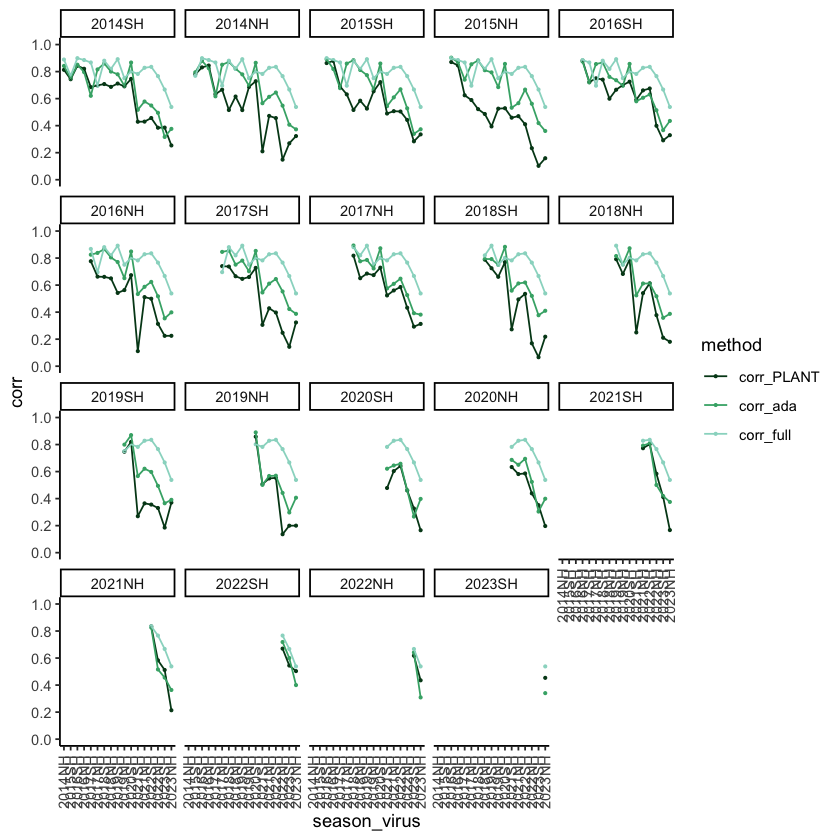

In [42]:

library(RColorBrewer)
color.v <- brewer.pal(9, "BuGn")[c(9,6,4,2)]

data_stat_corr <- data_stat_corr %>% mutate(method = factor(method, levels=c("corr_PLANT","corr_ada","corr_full", "corr_embed")))
data_stat_MAE <- data_stat_MAE %>%  mutate(method = factor(method, levels=c("MAE_PLANT","MAE_ada","MAE_full", "MAE_embed")))

g <- ggplot(data_stat_corr, aes(x=season_virus,y = corr, group = method, color = method)) +
  geom_point(size = 0.5) +
  geom_line(stat="identity") +
  scale_color_manual(values = color.v) +
  theme_classic() +
  facet_wrap(~dataset) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

g
pdf.name <- paste(prefix, "/corr_each_season.pdf",sep="")
pdf(pdf.name, width = 12, height = 6)
g
dev.off()


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


pdf 
  2

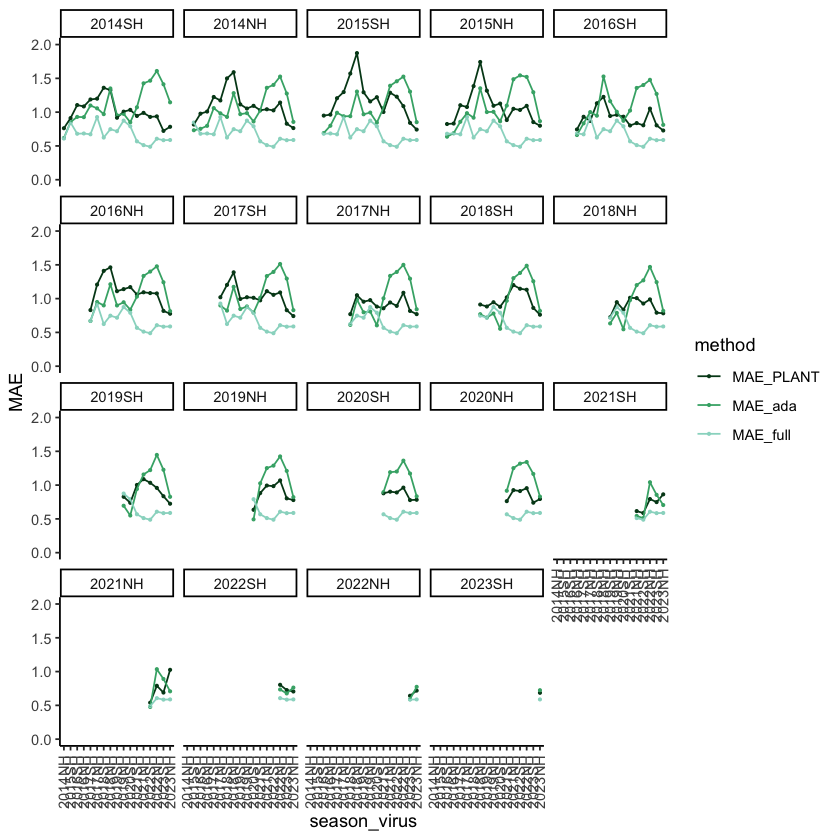

In [43]:
g <- ggplot(data_stat_MAE, aes(x=season_virus,y = MAE, group = method, color = method)) +
  geom_point(size = 0.5) +
  geom_line(stat="identity") +
  scale_color_manual(values = color.v) +
  theme_classic() +
  facet_wrap(~dataset) +
  ylim(0,2)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

g
pdf.name <- paste(prefix, "/MAE_each_season.pdf",sep="")
pdf(pdf.name, width = 12, height = 6)
g
dev.off()

In [44]:
data_stat_corr.scaled <- data_stat %>% select(dataset, season_virus, corr_PLANT, corr_ada) %>% gather(key=method, value=corr, -dataset, -season_virus)
data_stat_MAE.scaled <- data_stat %>% select(dataset, season_virus, MAE_PLANT, MAE_ada) %>% gather(key=method, value=MAE, -dataset, -season_virus)

data_stat_corr.scaled <- data_stat_corr.scaled %>% mutate(season_diff = as.numeric(season_virus) - as.numeric(dataset))
data_stat_MAE.scaled <- data_stat_MAE.scaled %>% mutate(season_diff = as.numeric(season_virus) - as.numeric(dataset))

data_stat_corr.scaled <- data_stat_corr.scaled %>% mutate(method = factor(method, levels = c("corr_PLANT","corr_ada")))
data_stat_MAE.scaled <- data_stat_MAE.scaled %>% mutate(method = factor(method, levels = c("MAE_PLANT","MAE_ada")))

In [45]:

# BuGnの19色を生成（maxは9なので、colorRampPaletteで補間）
buGn_colors <- colorRampPalette(c(brewer.pal(9, "YlOrBr")[4:9],"black"))(19)

# corrプロット
g.corr_all <- ggplot(
  data_stat_corr.scaled %>% mutate(method_dataset = paste(method, dataset)),
  aes(x = season_virus, y = corr, color = dataset, group = method_dataset)
) +
  geom_point() + geom_line() +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
  facet_wrap(~method) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
  scale_color_manual(values = buGn_colors)


# MAEプロット
g.MAE_all <- ggplot(
  data_stat_MAE.scaled %>% mutate(method_dataset = paste(method, dataset)),
  aes(x = season_virus, y = MAE, color = dataset, group = method_dataset)
) +
  geom_point() + geom_line() +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
  facet_wrap(~method) +
  ylim(0,2) +
  scale_color_manual(values = buGn_colors)


`summarise()` has grouped output by 'season_diff'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'season_diff'. You can override using the
`.groups` argument.


pdf 
  2

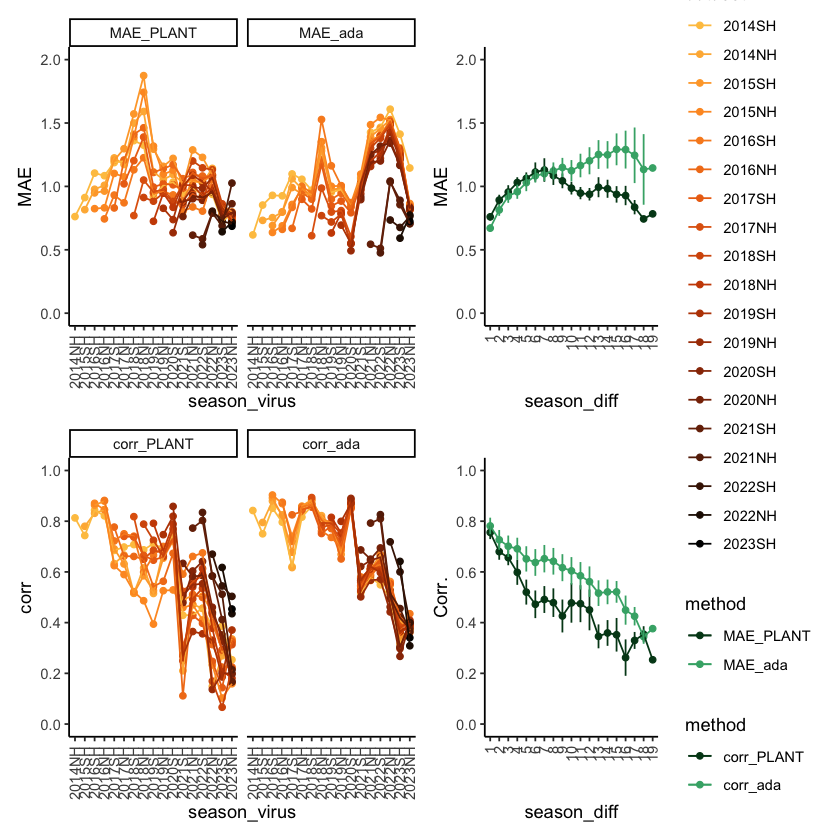

In [46]:

data_stat_corr.scaled.mean <- data_stat_corr.scaled %>%
  filter(!is.na(corr)) %>%
  mutate(season_diff = factor(season_diff, sort(unique(data_stat_corr.scaled$season_diff)))) %>%
  group_by(season_diff, method) %>%
  summarize(mean = mean(corr), sd = sd(corr), n = n()) %>%
  mutate(se = sd / sqrt(n))  # `se`を計算

data_stat_MAE.scaled.mean <- data_stat_MAE.scaled %>%
  filter(!is.na(MAE)) %>%
  mutate(season_diff = factor(season_diff, sort(unique(data_stat_MAE.scaled$season_diff)))) %>%
  group_by(season_diff, method) %>%
  summarize(mean = mean(MAE), sd = sd(MAE), n = n()) %>%
  mutate(se = sd / sqrt(n))  # `se`を計算


data_stat_corr.scaled.mean <- data_stat_corr.scaled.mean %>% mutate(method = factor(method, levels=c("corr_PLANT","corr_ada")))
data_stat_MAE.scaled.mean <- data_stat_MAE.scaled.mean %>% mutate(method = factor(method, levels=c("MAE_PLANT","MAE_ada")))


g.corr_mean <- ggplot(data_stat_corr.scaled.mean, aes(x = season_diff, y = mean, group = method, color = method)) +
  geom_point() +
  geom_line(stat = "identity") +
  geom_errorbar(aes(ymin = mean - se, ymax = mean + se), width = 0) +  # エラーバーの追加
  scale_color_manual(values = color.v) +
  theme_classic() +
  labs(y = "Corr.") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2))

g.MAE_mean <- ggplot(data_stat_MAE.scaled.mean, aes(x = season_diff, y = mean, group = method, color = method)) +
  geom_point() +
  geom_line(stat = "identity") +
  geom_errorbar(aes(ymin = mean - se, ymax = mean + se), width = 0) +  # エラーバーの追加
  scale_color_manual(values = color.v) +
  theme_classic() +
  labs(y = "MAE") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  ylim(0,2)





# 上段と下段を別々に構成してから縦に結合
top_row <- g.MAE_all + g.MAE_mean + plot_layout(widths = c(2, 1))
bottom_row <- g.corr_all + g.corr_mean + plot_layout(widths = c(2, 1))

# 上下段を縦に並べ、全体のガイドを統合
final_plot <- top_row / bottom_row + plot_layout(guides = "collect")


final_plot 

pdf.name <- paste(prefix, "/MAE_corr_PLANT_Adaboost_each_season_with_2014SH.pdf",sep="")
pdf(pdf.name, width = 12, height = 5)
final_plot
dev.off()